# Data Loading

In [1]:
import pandas as pd

game_df = pd.read_json('../data/trimmed_games.json')

# Data Filtering

In [2]:
# trim game_df
bad_cols = ["age", "date", "year", "player_id", "team", "opponent", "player_team_score", "opponent_score", "game_number"]
trim_df = game_df.drop(columns=bad_cols)
trim_df = trim_df[(trim_df.iloc[:,2:] != 0).any(axis=1)]

# convert game location and game won to 1s and 0s
trim_df["game_location"] = trim_df["game_location"].map({"A":0, "H":1})
trim_df["game_won"] = trim_df["game_won"].map({False:0, True:1})
trim_df = trim_df.dropna()



#isolate offense and defense data
offense_cols = ['passing_attempts','passing_completions','passing_yards',
            'passing_rating','passing_touchdowns','passing_interceptions',
            'passing_sacks','passing_sacks_yards_lost','rushing_attempts',
            'rushing_yards','rushing_touchdowns','receiving_targets',
            'receiving_receptions','receiving_yards','receiving_touchdowns']

defense_cols = ['defense_sacks', 'defense_tackles','defense_tackle_assists', 'defense_interceptions',
            'defense_interception_yards','defense_interception_touchdowns','defense_safeties']

special_teams = ['kick_return_attempts','kick_return_yards', 'kick_return_touchdowns',
            'punt_return_attempts', 'punt_return_yards', 'punt_return_touchdowns', 'point_after_attemps','point_after_makes','field_goal_attempts',
            'field_goal_makes','punting_attempts','punting_yards','punting_blocked']

offense = trim_df[(trim_df[offense_cols] != 0).any(axis=1)]
offense = offense.drop(columns=defense_cols+special_teams)
defense = trim_df[(trim_df[defense_cols] != 0).any(axis=1)]
defense = defense.drop(columns=offense_cols+special_teams)

y_offense = offense['game_won']
offense.drop(columns=["game_won"],inplace=True)

y_defense = defense['game_won']
defense.drop(columns=["game_won"],inplace=True)

# RandomForest

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn import tree

# Helper function to run RandomForest on a data.
def RF(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    # Create a Random Forest Classifier
    rf_classifier = RandomForestClassifier(random_state=10)

    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=11)
    clf.fit(X_train, y_train)
    
    # Train the classifier on the training data
    rf_classifier.fit(X_train, y_train)
    
    # Make predictions on the train data
    train_pred = rf_classifier.predict(X_train)
    
    # Make predictions on the test data
    y_pred = rf_classifier.predict(X_test)

    dt_train_pred = clf.predict(X_train)
    dt_test_pred = clf.predict(X_test)
    
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_train, train_pred)
    print(f"Train Accuracy: {accuracy}")
    
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy}")

    print("Decision Tree")
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_train, dt_train_pred)
    print(f"Train Accuracy: {accuracy}")
    
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, dt_test_pred)
    print(f"Test Accuracy: {accuracy}")

print("Offense:")
RF(offense.to_numpy(), y_offense)

print("Defense:")
RF(defense.to_numpy(), y_defense)

Offense:
Train Accuracy: 0.8096342055945027
Test Accuracy: 0.594536065300683
Decision Tree
Train Accuracy: 0.6345942944402027
Test Accuracy: 0.6071408740074408
Defense:
Train Accuracy: 0.6042991525103575
Test Accuracy: 0.5822797562081298
Decision Tree
Train Accuracy: 0.5960131467932654
Test Accuracy: 0.5853523396967713


# Hyperparameter Testing

In [44]:
from sklearn.model_selection import GridSearchCV

# Helper function to perform hyperparameter tuning on RandomForest
def tune_RF(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

    # Create a Random Forest Classifier
    rf_classifier = RandomForestClassifier(random_state=10)

    # Define the hyperparameters and their possible values
    param_grid = {
        'n_estimators': [100, 250, 500],
        'max_depth': [None, 10, 20, 30],
        'max_leaf_nodes': [None, 128],
        'min_samples_split': [2, 4, 8],
        'min_samples_leaf': [1, 2, 4, 8]
    }

    # Use GridSearchCV to find the best combination of hyperparameters
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters: {best_params}")

    # Train the classifier with the best hyperparameters on the training data
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=10)
    best_rf_classifier.fit(X_train, y_train)

    # Make predictions on the train data
    train_pred = best_rf_classifier.predict(X_train)

    # Make predictions on the test data
    y_pred = best_rf_classifier.predict(X_test)

    # Evaluate the accuracy of the model
    accuracy_train = accuracy_score(y_train, train_pred)
    print(f"Train Accuracy: {accuracy_train}")

    # Evaluate the accuracy of the model on the test data
    accuracy_test = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy_test}")

# Example usage:
print("Offense:")
tune_RF(offense.to_numpy(), y_offense)

print("Defense:")
tune_RF(defense.to_numpy(), y_defense)

Offense:
Best Hyperparameters: {'max_depth': None, 'max_leaf_nodes': 128, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Train Accuracy: 0.6308461164711598
Test Accuracy: 0.6149147648398023
Defense:
Best Hyperparameters: {'max_depth': 10, 'max_leaf_nodes': 128, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Train Accuracy: 0.5939731271486318
Test Accuracy: 0.5876693698685337


# Offense Model with Hyperparameters

Train Accuracy: 0.6355799264246547
Test Accuracy: 0.6203009606307958
Confusion Matrix:
[[5830 3204]
 [3634 5341]]


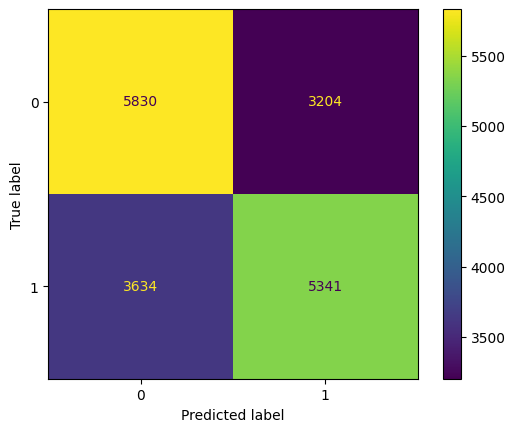

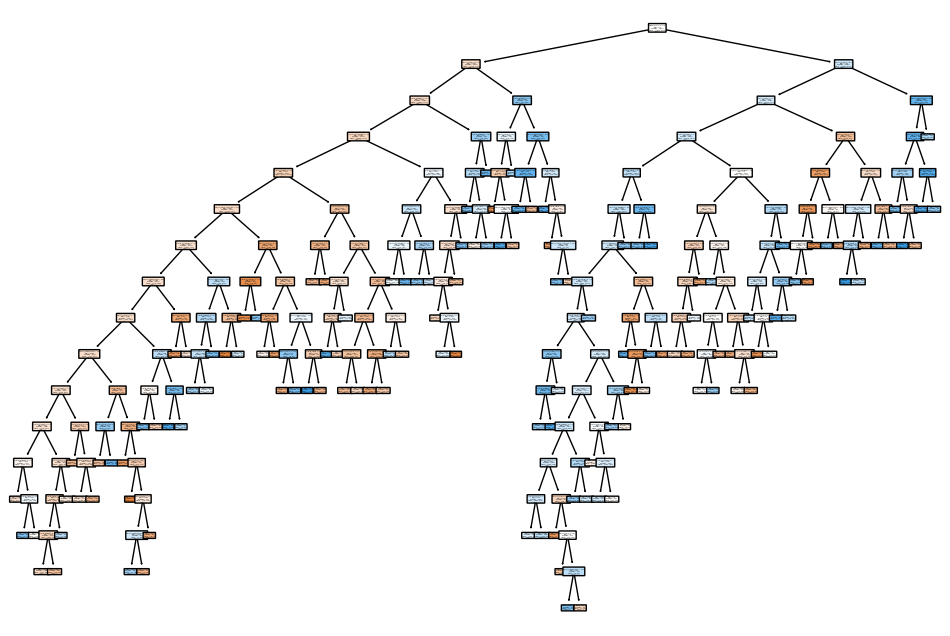

In [9]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(offense.to_numpy(), y_offense, test_size=0.2, random_state=10)

# These params are based off the hyperparam. testing above
off_rf = RandomForestClassifier(max_features=None, max_depth=None, max_leaf_nodes=128, n_estimators=500, random_state=10, min_samples_leaf=4, criterion='gini')
off_rf.fit(X_train, y_train)

# Make predictions on the train data
train_pred = off_rf.predict(X_train)

# Make predictions on the test data
y_pred = off_rf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_train, train_pred)
print(f"Train Accuracy: {accuracy}")

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=off_rf.classes_)
disp.plot()
plt.savefig('off_rf_conf.png', dpi=500)

# Plot a random tree from the forest
plt.figure(figsize=(12, 8))
plot_tree(off_rf.estimators_[0], feature_names=offense.columns.tolist(), class_names=['0', '1'], filled=True, rounded=True)
plt.savefig('off_rf_tree.png', dpi=500)
plt.show()

# Defense Model with Hyperparameters

Train Accuracy: 0.5939479417209202
Test Accuracy: 0.5866619654460283


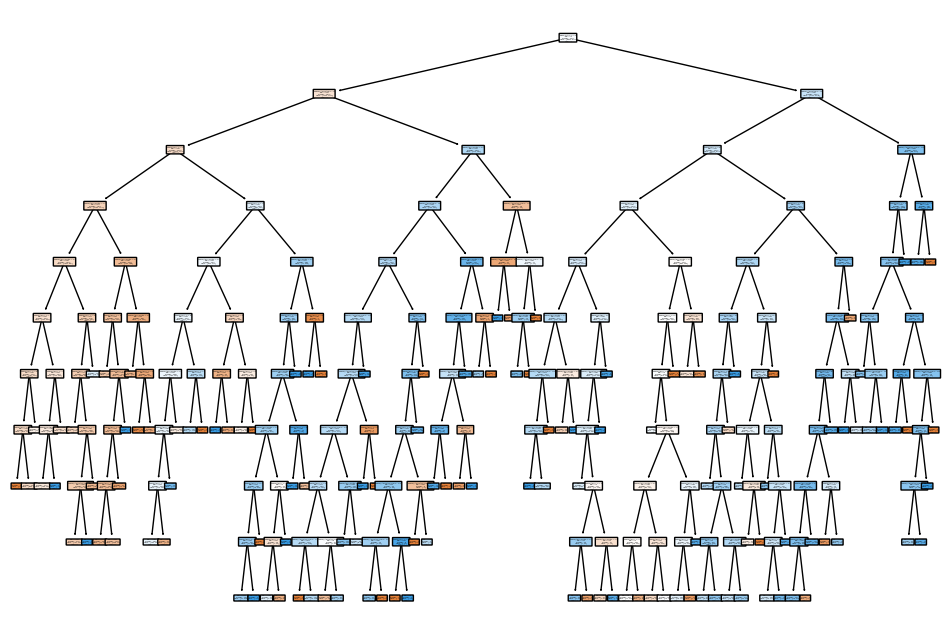

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(defense.to_numpy(), y_defense, test_size=0.2, random_state=10)

# These params are based off the hyperparam. testing above
def_rf = RandomForestClassifier(max_features=None, max_depth=10, max_leaf_nodes=128, n_estimators=500, random_state=10, min_samples_leaf=1, min_samples_split=2)
def_rf.fit(X_train, y_train)

# Make predictions on the train data
train_pred = def_rf.predict(X_train)

# Make predictions on the test data
y_pred = def_rf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_train, train_pred)
print(f"Train Accuracy: {accuracy}")

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

# Plot a random tree from the forest
plt.figure(figsize=(12, 8))
plot_tree(def_rf.estimators_[0], feature_names=defense.columns.tolist(), class_names=['0', '1'], filled=True, rounded=True)
plt.savefig('def_rf_tree.png', dpi=500)
plt.show()